<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/VIT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install timm


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
import timm  # For using pretrained Vision Transformer models

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d')
checkpoint_folder = f'/content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Typical input size for ViT models
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize to match pretrained models' expectations
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalize to match pretrained models' expectations
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Use Pre-trained Vision Transformer (ViT) model and modify it for binary classification
class ViTModified(nn.Module):
    def __init__(self):
        super(ViTModified, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_ftrs = self.vit.head.in_features
        self.vit.head = nn.Linear(num_ftrs, 2)  # Modify the classifier to output 2 classes

    def forward(self, x):
        return self.vit(x)

# Initialize the ViT model
model = ViTModified()

# Define loss function and optimizer with L2 regularization (weight decay)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Training loop with learning rate scheduler
# Training loop with learning rate scheduler and checkpoint saving
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print the loss per epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.6f}")

        # Validate the model and check accuracy
        val_acc = validate(model, val_loader, criterion)
        val_accuracies.append(val_acc)
        scheduler.step(val_acc)

        # Save checkpoint of the latest model after each epoch
        latest_model_path = os.path.join(checkpoint_folder, f"latest_model_vit_{date_str}_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), latest_model_path)
        print(f"Checkpoint saved for epoch {epoch + 1} at {latest_model_path}")

        # Save the best model if the accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_path = os.path.join(checkpoint_folder, f"best_model_vit_{date_str}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_acc:.2f}% at {best_model_path}")

    # Plot training loss and validation accuracy curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save the final model at the end of training
    final_model_path = os.path.join(checkpoint_folder, f"final_model_vit_{date_str}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")


# Validation loop returning accuracy
def validate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')
    return accuracy

# Test function to evaluate on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader):.6f}, Test Accuracy: {accuracy:.2f}%')

# Run the full code sequence

# Step 1: Train the model with learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20)

# Step 2: Evaluate the model on the test set
test(model, test_loader, criterion)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 0.293969
Validation Accuracy: 96.84%
Checkpoint saved for epoch 1 at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/latest_model_vit_20241114_epoch1.pth
New best model saved with accuracy: 96.84% at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/best_model_vit_20241114.pth
Epoch [2/20], Loss: 0.098213
Validation Accuracy: 96.20%
Checkpoint saved for epoch 2 at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/latest_model_vit_20241114_epoch2.pth
Epoch [3/20], Loss: 0.078977
Validation Accuracy: 98.10%
Checkpoint saved for epoch 3 at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/latest_model_vit_20241114_epoch3.pth
New best model saved with accuracy: 98.10% at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/best_model_vit_20241114.pth
Epoch [4/20], Loss: 0.075795
Validation Accuracy: 96.20%
Checkpoint saved for epoch 4 at /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/l

Mounted at /content/drive
Model checkpoint found.
Image file found.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-1-d46388994dc2>:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Model loaded successfully from /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241112/best_model_vit_20241112.pth


<ipython-input-1-d46388994dc2>:119: RuntimeWarning: invalid value encountered in divide
  cam /= cam.max()  # Normalize between 0 and 1
<ipython-input-1-d46388994dc2>:128: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask_resized), cv2.COLORMAP_JET)


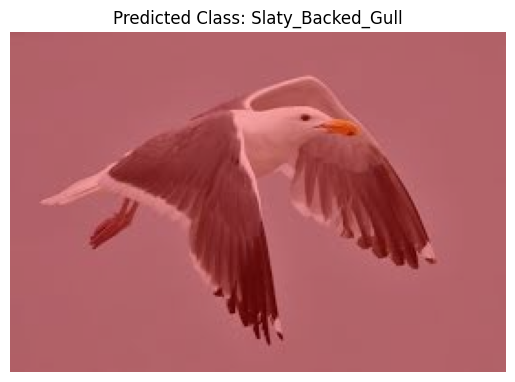

In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import timm  # Library for pretrained ViT models from timm
from google.colab import drive  # For connecting to Google Drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Define paths to your model checkpoint and test image in Google Drive
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241112/best_model_vit_20241112.pth'
# image_path = '/content/drive/My Drive/FYP/test data/007.jpg'
image_path = '/content/sbg.jpg' # Update with actual path to image

# Check if paths are correct
if not os.path.exists(checkpoint_path):
    print("Model checkpoint not found. Check the path.")
else:
    print("Model checkpoint found.")

if not os.path.exists(image_path):
    print("Image file not found. Check the path.")
else:
    print("Image file found.")

# Continue with model loading and visualization steps if paths are valid
# Define class names for your model output
class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']  # Update these as per your dataset

# Function to get predicted class
def get_predicted_class(model, input_tensor):
    model.eval()
    output = model(input_tensor)
    _, predicted_idx = torch.max(output, 1)
    predicted_class = class_names[predicted_idx.item()]
    return predicted_class

# Step 2: Define the modified ViT model with a binary classifier head
class ViTModified(nn.Module):
    def __init__(self):
        super(ViTModified, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_ftrs = self.vit.head.in_features
        self.vit.head = nn.Linear(num_ftrs, 2)  # Binary output for two classes

    def forward(self, x):
        return self.vit(x)

# Step 3: Load the model from the checkpoint
def load_vit_model(checkpoint_path):
    model = ViTModified()
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.eval()
    print("Model loaded successfully from", checkpoint_path)
    return model

# Load the ViT model
model = load_vit_model(checkpoint_path)

# Step 4: Grad-CAM Visualization
class ViTGradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = self._find_layer(target_layer_name)
        self.gradients = None
        self.activations = None

        # Register hooks to capture activations and gradients
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _find_layer(self, layer_name):
        return dict(self.model.named_modules())[layer_name]

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, class_idx=None):
        self.model.eval()

        # Forward pass
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()

        # Backward pass
        self.model.zero_grad()
        target = output[:, class_idx]
        target.backward()

        # Extract and process activations and gradients
        gradients = self.gradients.cpu().data.numpy().squeeze()
        activations = self.activations.cpu().data.numpy().squeeze()

        # Remove the [CLS] token (first token) for reshaping
        activations = activations[1:]
        gradients = gradients[1:]

        # Compute weights and apply to activations
        weights = np.mean(gradients, axis=0)
        cam = np.dot(activations, weights)

        # Reshape cam to (14, 14) grid
        cam = cam.reshape(14, 14)
        cam = np.maximum(cam, 0)  # ReLU to keep positive values

        # Resize cam to match input image size
        cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))
        cam -= cam.min()
        cam /= cam.max()  # Normalize between 0 and 1
        return cam

# Function to display Grad-CAM heatmap overlay with predicted class
def show_cam_on_image(img, mask, predicted_class):
    mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))
    mask_resized -= np.min(mask_resized)
    if np.max(mask_resized) != 0:  # Prevent division by zero
        mask_resized /= np.max(mask_resized)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask_resized), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    plt.imshow(cam)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')
    plt.show()

# Step 5: Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_np = np.array(image) / 255.0

# Get the predicted class for the image
predicted_class = get_predicted_class(model, input_tensor)

# Generate and display Grad-CAM
grad_cam = ViTGradCAM(model, target_layer_name="vit.blocks.11")
heatmap = grad_cam.generate_heatmap(input_tensor)
show_cam_on_image(image_np, heatmap, predicted_class)


CONF MATRIX

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-c4c13c7eb1c9>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


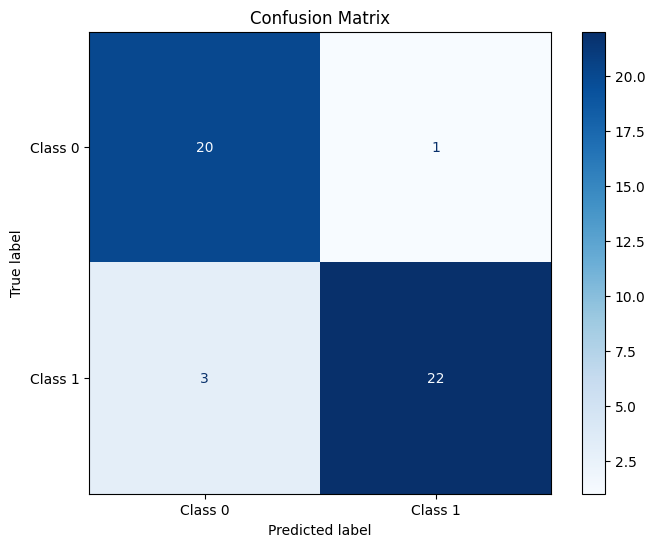

In [2]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Mount Google Drive
drive.mount('/content/drive')

# Path to model checkpoint in Google Drive
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241114/best_model_vit_20241114.pth'

# Define the model architecture based on your ViTModified class
class ViTModified(nn.Module):
    def __init__(self):
        super(ViTModified, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_ftrs = self.vit.head.in_features
        self.vit.head = nn.Linear(num_ftrs, 2)  # Binary classification

    def forward(self, x):
        return self.vit(x)

# Load the model and checkpoint
model = ViTModified()
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set up data transforms (matching test transforms)
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

# Load the test dataset
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/test'
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Class names (replace with actual names if known)
class_names = ["Class 0", "Class 1"]

# Collect true and predicted labels
y_true = []
y_pred = []

# Run model on test dataset
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import timm  # Library for pretrained ViT models from timm
from google.colab import drive  # For connecting to Google Drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Define paths to your model checkpoint and test image in Google Drive
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241112/best_model_vit_20241112.pth'
image_path = '/content/drive/My Drive/FYP/test data/007.jpg'  # Update with actual path to image

# Define class names for your model output
class_names = ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']  # Update these as per your dataset

# Step 2: Define the modified ViT model with a binary classifier head
class ViTModified(nn.Module):
    def __init__(self):
        super(ViTModified, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_ftrs = self.vit.head.in_features
        self.vit.head = nn.Linear(num_ftrs, 2)  # Binary output for two classes

    def forward(self, x):
        return self.vit(x)

# Load the ViT model
def load_vit_model(checkpoint_path):
    model = ViTModified()
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.eval()
    print("Model loaded successfully from", checkpoint_path)
    return model

model = load_vit_model(checkpoint_path)

# Step 3: Adjusted function to extract and visualize attention as a heatmap overlay
def visualize_attention_heatmap(model, input_tensor, image_np, layer_idx=-1, head_idx=0):
    """
    Visualizes attention for the [CLS] token on a specific layer and head as a heatmap overlay.
    Arguments:
    - model: The ViT model
    - input_tensor: Preprocessed input image tensor
    - image_np: Original image as a numpy array
    - layer_idx: The layer to visualize (default is -1, the last layer)
    - head_idx: The attention head to visualize (default is 0)
    """
    # Set model to eval mode and initialize storage for attention weights
    model.eval()
    attention_weights = None

    # Hook function to capture attention weights from the specified layer's attention module
    def hook(module, input, output):
        nonlocal attention_weights
        # Extract the attention weights directly from the module, assuming it’s available as `module.attention`
        attention_weights = module.attention.detach().cpu() if hasattr(module, 'attention') else output.detach().cpu()

    # Register the hook to the specified layer's attention module
    handle = model.vit.blocks[layer_idx].attn.register_forward_hook(hook)

    # Perform a forward pass to trigger the hook and capture attention weights
    with torch.no_grad():
        _ = model(input_tensor)

    # Remove the hook after the forward pass
    handle.remove()

    # Ensure attention_weights was captured
    if attention_weights is None:
        print("Failed to capture attention weights. Check if the specified layer and head are correct.")
        return

    # Extract attention for the specified head and the CLS token
    cls_attention = attention_weights[0, head_idx, 0, 1:].reshape(14, 14).numpy()

    # Normalize and resize the attention map to the original image dimensions
    cls_attention -= cls_attention.min()
    cls_attention /= cls_attention.max()
    attention_map = cv2.resize(cls_attention, (image_np.shape[1], image_np.shape[0]))

    # Create a heatmap from the attention map
    heatmap = cv2.applyColorMap(np.uint8(255 * attention_map), cv2.COLORMAP_JET)
    overlay = np.float32(heatmap) / 255 + np.float32(image_np)
    overlay = overlay / overlay.max()  # Normalize for display

    # Display the attention map overlay
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.title(f'Attention Heatmap - Layer {layer_idx + 1}, Head {head_idx + 1}')
    plt.axis('off')
    plt.show()

# Step 5: Generate and display the attention heatmap
visualize_attention_heatmap(model, input_tensor, image_np, layer_idx=-1, head_idx=0)


# Step 5: Generate and display the attention heatmap
visualize_attention_heatmap(model, input_tensor, image_np, layer_idx=-1, head_idx=0)


# Step 5: Generate and display the attention heatmap
visualize_attention_heatmap(model, input_tensor, image_np, layer_idx=-1, head_idx=0)


# Step 4: Load and preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_np = np.array(image) / 255.0

# Step 5: Generate and display the attention map
visualize_attention_single_layer(model, input_tensor, image_np, layer_idx=-1, head_idx=0)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-8-022b0d3db06a>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Model loaded successfully from /content/drive/My Drive/FYP/ModelCheckpointsHQltst_ViT_20241112/best_model_vit_20241112.pth


IndexError: too many indices for tensor of dimension 3